In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os
import pandas as pd
import matplotlib.offsetbox as offsetbox

In [2]:
# Dictionary of standard (LEADER) model colours
col_dict = {'ACCESS-ESM1-5':'#7f3c8d','CanESM5':'#11a579','CMCC-CM2-SR5':'#3969ac','CNRM-CM6-1':'red','FGOALS-g3':'#f2b701','GISS-E2-1-G':'#e73f74','HadGEM3-GC31-LL':'#80ba5a','IPSL-CM6A-LR':'#e68310','MIROC6':'#008695','MPI-ESM1-2-LR':'#cf1c90','NorESM2-LM':'#f97b72'}
exp_col_dict = {"hist-totalO3": "#66c5cc",
	"hist-sol": 	"#f6cf71",
	"hist-volc":	"#f89c74",
	"unlabeled_1":  "#dcb0f2",  # rename if needed    
	"hist-aer": 	"#87c55f",
	"unlabeled_2":  "#9eb9f3",  # rename if needed
	"hist-GHG": 	"#fe88b1",
	"hist-nat": 	"#c9db74",
	"hist-total03":  "#8be0a4",  # rename if needed    
	"historical":   "#b497e7",
	"observations": "#b3b3b3"
}

In [3]:
def calculate_NAO_trend(ds, year_init, year_final, period_init, variable, time_variable):

    #creating an empty array for the trend which will be appended to and then outputted
    #got to convert into amount of years between, there is a +1 due to python's indexing finishing before the last one (I want to include 0 and end)
    #not currently outputting the intercept but could I I need it
    NAO_trend_slope = np.zeros(year_final - year_init - period_init)
    NAO_trend_intercept = np.zeros(year_final - year_init - period_init)
    
    #opening dataset
    #ds = xr.open_dataset(filepath)
    
    period_end = (year_init + period_init)
    trend_period = period_init
    i = 0

    while period_end < year_final:
        #Taking slice of dataset to perform the linregress on
        ds_slice = ds[variable].sel({time_variable: slice(year_init,year_init+trend_period)}).values
        
        # time as a simple integer array, the +1 comes from matching to the line above when slicing between initial year and initial year + trend period.        
        time_numeric = np.arange(trend_period+1)

        # Perform the regression using linregress (returns slope, intercept, r_value, p_value, std_err)
        reg_slope, reg_intercept, _, _, _ = linregress(time_numeric, ds_slice)
    
        # Store the results within the arrays made earlier
        NAO_trend_slope[i] = reg_slope
        NAO_trend_intercept[i] = reg_intercept

        #increasing the enddate, trend_period ( to update the numeric time array) and the index i.
        period_end = period_end + 1
        trend_period = trend_period + 1
        i = i + 1
        

    return NAO_trend_slope

def get_ensemble_means_timeseries_files(folder_path):
    #function which will loop through a folder (my folders are by experiment) to find all the relevant EM files
    ens_means_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if '_EM_' in filename]
    return ens_means_files

def get_multimodel_mean(files, variable):
    #this will open each file within files (list)
    #then calculate the mean across them (multimodel mean)
    #then it will output this data as an array

    data_arrays = []
    
    #looping over all files
    for file in files:
        #opening the dataset for one file
        ds = xr.open_dataset(file, engine='netcdf4')

        #appending the timeseries data to the array
        data_arrays.append(ds[variable])

    #calculating the mean
    multimodel_mean = np.mean([da.values for da in data_arrays], axis=0)

    #creating an array of the mean
    multimodel_da = xr.DataArray(multimodel_mean, coords=data_arrays[0].coords, dims=data_arrays[0].dims)

    return multimodel_da


In [93]:
#Want to open the dataset and then change the start years. Then change the end years - but need them kinda both changing at th same time.
#Yeah so change the start year loop and within that the change the end year loop.
#acall function. Get trend value returned
#save this to a datasturcture (ensembles, start year (1951-2013), end year (1952-2014))

variable = 'psl'
model = ['HadGEM3-GC31-LL']
start_years = np.arange(1951, 2014)
end_year = 2015
end_years = np.arange(1952,2015)
ensemble_trends = []
model_trend_list = []

for m in model:
    #looping through each model to find the filenames of the nao timeseries for each ensemble member and ensemble_mean
    folderpath = '/gws/nopw/j04/extant/users/slbennie/projection_indicies/NAO/historical/' + m + '/'
    filepaths = [os.path.join(folderpath, filename) for filename in os.listdir(folderpath) if m in filename and '_EM_' not in filename]# and'r11i1' in filename]
    for f in filepaths:
        #looping through each ensembles filepath name for that model
        ds = xr.open_dataset(f)
        trend_matrix = np.full((len(start_years), len(end_years)), np.nan)
        
        for i, start in enumerate(start_years):
            valid_end_mask = end_years > start

            try:
                trend = calculate_NAO_trend(ds,start,end_year,1, variable, 'year')
                if trend.shape[0] != valid_end_mask.sum():
                    raise ValueError(f"Expected {valid_end_mask.sum()} trends, got {trend.shape[0]}")
                trend_matrix[i, valid_end_mask] = trend * 10

            except Exception as e:
                print(f"Trend calc failed for {f}, start={start}: {e}")

        ensemble_trends.append(trend_matrix)


ensemble_ids = [f"ens_{i}" for i in range(len(ensemble_trends))]

trend_da = xr.DataArray(
    data=np.array(ensemble_trends),  # shape: (ensemble, start_year, end_year)
    dims=["ensemble", "start_year", "end_year"],
    coords={
        "ensemble": ensemble_ids,
        "start_year": start_years,
        "end_year": end_years
    },
    name="nao_trend"
)

#trend_da.to_netcdf('/gws/nopw/j04/extant/users/slbennie/NA_WG_trend_sensitivty.nc')

In [4]:
import numpy as np
import os
import xarray as xr

variable = 'psl'
#models = ['HadGEM3-GC31-LL']
models = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','FGOALS-g3','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']#for historical - removed GISS as issues with time on that one.
start_years = np.arange(1951, 2014)
end_years = np.arange(1952, 2015)
end_year = 2015

model_trend_list = []      # Holds trend matrices for all models
model_names = []           # Holds corresponding model names
ensemble_ids_all = []      # Holds ensemble IDs for each model

for m in models:
    print(f"Processing model: {m}")
    folderpath = f'/gws/nopw/j04/extant/users/slbennie/projection_indicies/NAO/historical/{m}/'
    filepaths = [
        os.path.join(folderpath, filename)
        for filename in os.listdir(folderpath)
        if m in filename and '_EM_' not in filename# and 'r11i1' in filename
    ]
    
    model_ensembles = []

    for f in filepaths:
        ds = xr.open_dataset(f)
        trend_matrix = np.full((len(start_years), len(end_years)), np.nan)
        
        for i, start in enumerate(start_years):
            valid_end_mask = end_years > start
            try:
                trend = calculate_NAO_trend(ds, start, end_year, 1, variable, 'year')
                if trend.shape[0] != valid_end_mask.sum():
                    raise ValueError(f"Expected {valid_end_mask.sum()} trends, got {trend.shape[0]}")
                trend_matrix[i, valid_end_mask] = trend * 10
            except Exception as e:
                print(f"Trend calc failed for {f}, start={start}: {e}")
        
        model_ensembles.append(trend_matrix)
    
    model_trend_list.append(np.array(model_ensembles))
    model_names.append(m)
    ensemble_ids_all.append([f"{m}_ens_{i}" for i in range(len(model_ensembles))])

# Build final DataArray
trend_da = xr.DataArray(
    data=np.array(model_trend_list),  # shape: (model, ensemble, start_year, end_year)
    dims=["model", "ensemble", "start_year", "end_year"],
    coords={
        "model": model_names,
        "ensemble": ensemble_ids_all[0] if len(models) == 1 else np.concatenate(ensemble_ids_all),
        "start_year": start_years,
        "end_year": end_years
    },
    name="nao_trend"
)



Processing model: ACCESS-ESM1-5
Processing model: CanESM5
Processing model: CMCC-CM2-SR5
Processing model: FGOALS-g3
Processing model: GISS-E2-1-G
Processing model: HadGEM3-GC31-LL
Processing model: IPSL-CM6A-LR
Processing model: MIROC6
Processing model: MPI-ESM1-2-LR
Processing model: NorESM2-LM


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

In [5]:
# Flatten everything: stack all ensembles across all models
all_ensemble_data = []
all_ensemble_ids = []
all_model_ids = []

for model_name, trend_matrices, ens_ids in zip(model_names, model_trend_list, ensemble_ids_all):
    for ens_matrix, ens_id in zip(trend_matrices, ens_ids):
        all_ensemble_data.append(ens_matrix)
        all_ensemble_ids.append(ens_id)
        all_model_ids.append(model_name)

# Now convert to single 3D array: (ensemble, start_year, end_year)
trend_array = np.array(all_ensemble_data)

# Final DataArray
trend_da = xr.DataArray(
    data=trend_array,
    dims=["ensemble", "start_year", "end_year"],
    coords={
        "ensemble": all_ensemble_ids,
        "model": ("ensemble", all_model_ids),
        "start_year": start_years,
        "end_year": end_years
    },
    name="nao_trend"
)


In [6]:
print(trend_da)

<xarray.DataArray 'nao_trend' (ensemble: 396, start_year: 63, end_year: 63)> Size: 13MB
array([[[-9.99932058e+00, -1.80676694e-01, -1.24296427e+00, ...,
          5.42859636e-02,  5.57766542e-02,  5.67347178e-02],
        [            nan,  9.63796719e+00,  1.32172531e+00, ...,
          6.92853919e-02,  7.03403168e-02,  7.08664566e-02],
        [            nan,             nan, -6.99451657e+00, ...,
          6.87701748e-02,  6.98765797e-02,  7.04346511e-02],
        ...,
        [            nan,             nan,             nan, ...,
         -1.83074342e+01, -3.96507188e+00, -1.40719345e+00],
        [            nan,             nan,             nan, ...,
                     nan,  1.03772905e+01,  5.07884628e+00],
        [            nan,             nan,             nan, ...,
                     nan,             nan, -2.19597911e-01]],

       [[-2.48625350e+00,  9.41466729e-02, -5.34835078e+00, ...,
          3.24069090e-02,  3.32028363e-02,  1.09815619e-02],
        [      

In [7]:
#doing the same now but for era5 - want the structure to match but only one ensemble - era5.
variable = 'nao_timeseries_djf'
start_years = np.arange(1951, 2014)
end_year = 2015
end_years = np.arange(1952,2015)
era5_trends = []

era5 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/ERA5_2020/ERA5_1.cvdp_data.1940-2020.nc')

era5_trend_matrix = np.full((len(start_years), len(end_years)), np.nan)

for i, start in enumerate(start_years):
    valid_end_mask = end_years > start
    try:
        era5_trend = calculate_NAO_trend(era5, start, end_year, 1, variable, 'TIME')
        if era5_trend.shape[0] != valid_end_mask.sum():
            raise ValueError(f"Expected {valid_end_mask.sum()} trends, got {era5_trend.shape[0]}")
        era5_trend_matrix[i, valid_end_mask] = era5_trend * 10

    except Exception as e:
        print(f"Trend calc failed for {f}, start={start}: {e}")

era5_trends.append(era5_trend_matrix)

era5_ids = [f"ens_{i}" for i in range(len(era5_trends))]

era5_trend_da = xr.DataArray(
    data=np.array(era5_trends),  # shape: (ensemble, start_year, end_year)
    dims=["ensemble", "start_year", "end_year"],
    coords={
        "ensemble": era5_ids,
        "start_year": start_years,
        "end_year": end_years
    },
    name="nao_trend_era5"
)

#era5_trend_da.to_netcdf('/gws/nopw/j04/extant/users/slbennie/era5_NA_WG_NAO_index_trend_sensitivity.nc')
print(era5_trend_da)

# Broadcast start_year and end_year to match the 2D grid
start, end = xr.broadcast(era5_trend_da.start_year, era5_trend_da.end_year)

# Create the boolean mask where end_year - start_year > 20
long_period_mask = (end - start) > 20

masked_trends = era5_trend_da.where(long_period_mask)

<xarray.DataArray 'nao_trend_era5' (ensemble: 1, start_year: 63, end_year: 63)> Size: 32kB
array([[[ 10.15359133,   0.56603536,   0.66421603, ...,   0.14083761,
           0.12473351,   0.12916241],
        [         nan,  -9.02152061,  -2.46618219, ...,   0.14197179,
           0.12531162,   0.12986277],
        [         nan,          nan,   4.08915624, ...,   0.16019208,
           0.14238829,   0.14653539],
        ...,
        [         nan,          nan,          nan, ...,  23.28857303,
           1.36672825,   2.76844287],
        [         nan,          nan,          nan, ...,          nan,
         -20.55511653,  -3.60436231],
        [         nan,          nan,          nan, ...,          nan,
                  nan,  13.34639192]]])
Coordinates:
  * ensemble    (ensemble) <U5 20B 'ens_0'
  * start_year  (start_year) int64 504B 1951 1952 1953 1954 ... 2011 2012 2013
  * end_year    (end_year) int64 504B 1952 1953 1954 1955 ... 2012 2013 2014


In [17]:
trend_da.sel(model='HadGEM3-GC31-LL')

KeyError: "no index found for coordinate 'model'"

In [9]:
model = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','FGOALS-g3','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']#for historical - removed GISS as issues with time on that one.
tally_mask = xr.DataArray(
    np.zeros_like(era5_trend_da.sel(ensemble='ens_0').values, dtype=int),
    coords=era5_trend_da.sel(ensemble='ens_0').coords,
    dims=["start_year", "end_year"],
    name="era5_within_model_bounds_count"
)



for m in models:
    #selecting one model
    model_data = trend_da.sel(model=m)

    #finding the max and mins
    max_trends = model_data.max(dim='ensemble')
    min_trends = model_data.min(dim='ensemble')

    #finding the 2.5-97.5% for this model
    lower = min_trends + (2.5 * ((max_trends - min_trends)/100))
    upper = max_trends - (2.5 * ((max_trends - min_trends)/100))

    # Remove the "ensemble" dimension from ERA5 to align with lower/upper
    era5_data = era5_trend_da.sel(ensemble='ens_0')

    # Create mask: True where ERA5 trend lies within bounds
    within_bounds = (era5_data >= lower) & (era5_data <= upper)

    # Tally up where ERA5 is within model's range
    tally_mask = tally_mask + within_bounds.fillna(False).astype(int)


tally_mask.plot(cmap="Purples")
plt.title("Count of models where ERA5 lies within model bounds")
plt.show()

KeyError: "no index found for coordinate 'model'"

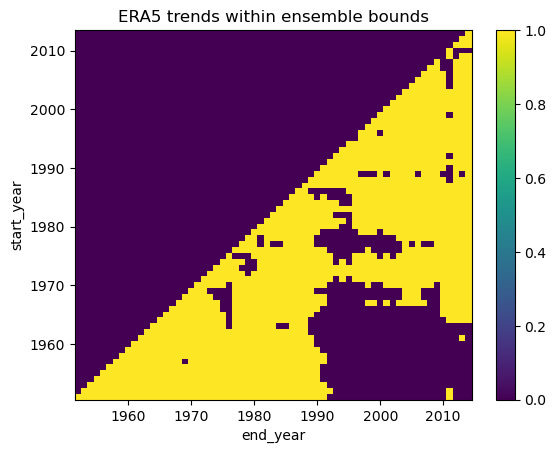

In [120]:
max_trends = trend_da.sel(model='HadGEM3-GC31-LL').max(dim='ensemble')
min_trends = trend_da.sel(model='HadGEM3-GC31-LL').min(dim='ensemble')

lower = min_trends + (2.5 * ((max_trends - min_trends)/100))
upper = max_trends - (2.5 * ((max_trends - min_trends)/100))

# Remove the "ensemble" dimension from ERA5 to align with lower/upper
era5_data = era5_trend_da.sel(ensemble='ens_0')

# Create mask: True where ERA5 trend lies within bounds
within_bounds_mask = (era5_data >= lower) & (era5_data <= upper)

# Optional: apply mask to ERA5 data
masked_era5 = era5_data.where(within_bounds_mask)

within_bounds_mask.plot()
plt.title("ERA5 trends within ensemble bounds")
plt.show()



In [64]:
#doing the same now but for era5 - want the structure to match but only one ensemble - era5.
variable = 'nao_timeseries_djf'
start_years = np.arange(1951, 2014)
end_year = 2015
end_years = np.arange(1952,2015)
era5_trends = []

era5 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/ERA5_2020/ERA5_1.cvdp_data.1940-2020.nc')

era5_trend_matrix = np.full((len(start_years), len(end_years)), np.nan)

for i, start in enumerate(start_years):
    valid_end_mask = end_years > start
    try:
        era5_trend = calculate_NAO_trend(era5, start, end_year, 1, variable, 'TIME')
        if era5_trend.shape[0] != valid_end_mask.sum():
            raise ValueError(f"Expected {valid_end_mask.sum()} trends, got {era5_trend.shape[0]}")
        era5_trend_matrix[i, valid_end_mask] = era5_trend * 10

    except Exception as e:
        print(f"Trend calc failed for {f}, start={start}: {e}")

era5_trends.append(era5_trend_matrix)

era5_ids = [f"ens_{i}" for i in range(len(era5_trends))]

era5_trend_da = xr.DataArray(
    data=np.array(era5_trends),  # shape: (ensemble, start_year, end_year)
    dims=["ensemble", "start_year", "end_year"],
    coords={
        "ensemble": era5_ids,
        "start_year": start_years,
        "end_year": end_years
    },
    name="nao_trend_era5"
)

#era5_trend_da.to_netcdf('/gws/nopw/j04/extant/users/slbennie/era5_NA_WG_NAO_index_trend_sensitivity.nc')
print(era5_trend_da)

# Broadcast start_year and end_year to match the 2D grid
start, end = xr.broadcast(era5_trend_da.start_year, era5_trend_da.end_year)

# Create the boolean mask where end_year - start_year > 20
long_period_mask = (end - start) > 20

masked_trends = era5_trend_da.where(long_period_mask)


<xarray.DataArray 'nao_trend_era5' (ensemble: 1, start_year: 63, end_year: 63)> Size: 32kB
array([[[ 10.15359133,   0.56603536,   0.66421603, ...,   0.14083761,
           0.12473351,   0.12916241],
        [         nan,  -9.02152061,  -2.46618219, ...,   0.14197179,
           0.12531162,   0.12986277],
        [         nan,          nan,   4.08915624, ...,   0.16019208,
           0.14238829,   0.14653539],
        ...,
        [         nan,          nan,          nan, ...,  23.28857303,
           1.36672825,   2.76844287],
        [         nan,          nan,          nan, ...,          nan,
         -20.55511653,  -3.60436231],
        [         nan,          nan,          nan, ...,          nan,
                  nan,  13.34639192]]])
Coordinates:
  * ensemble    (ensemble) <U5 20B 'ens_0'
  * start_year  (start_year) int64 504B 1951 1952 1953 1954 ... 2011 2012 2013
  * end_year    (end_year) int64 504B 1952 1953 1954 1955 ... 2012 2013 2014


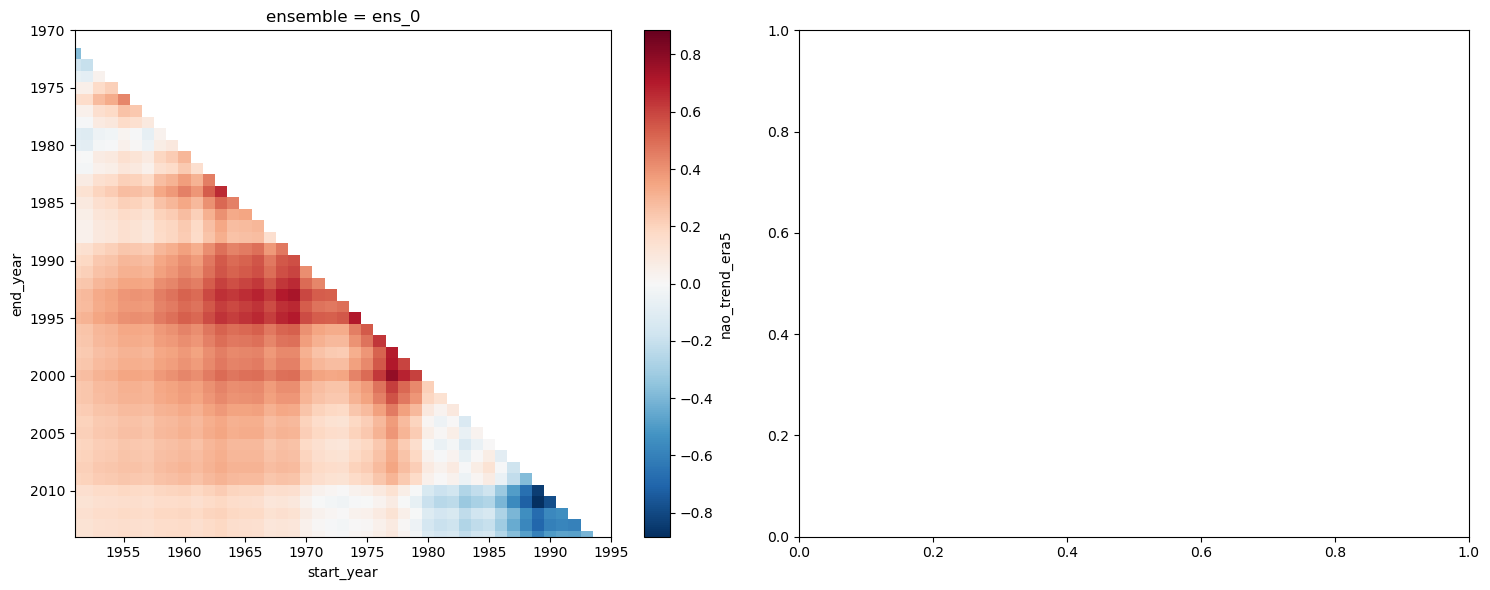

In [92]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

masked_trends.transpose("ensemble", "end_year", "start_year").plot(ax=ax[0])
ax[0].set_xlim(1951,1995)
ax[0].set_ylim(1970,2014)
ax[0].invert_yaxis()


#for plot 2. does era5 lie within the ensemble spread for each model? Need the mean and max and min for each model
#what actually si the 2.5-97.5% percentils is it percentage of range I guess.
#



plt.tight_layout()
plt.show()

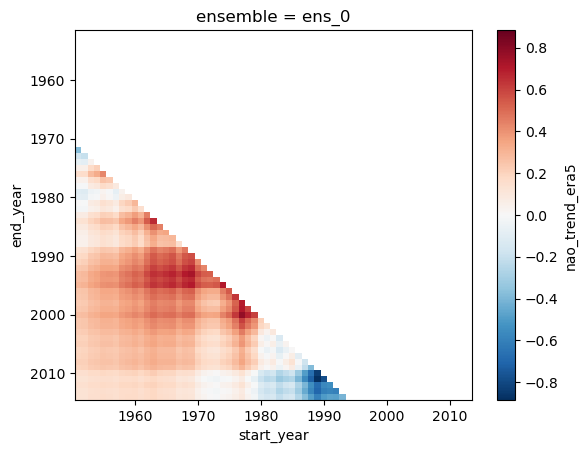

In [66]:
# Broadcast start_year and end_year to match the 2D grid
start, end = xr.broadcast(era5_trend_da.start_year, era5_trend_da.end_year)

# Create the boolean mask where end_year - start_year > 20
long_period_mask = (end - start) > 20

masked_trends = era5_trend_da.where(long_period_mask)

masked_trends.transpose("ensemble", "end_year", "start_year").plot()

# Flip the y-axis so end_year increases upward (right-hand side)
plt.gca().invert_yaxis()
plt.show()


In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

#FIGURE a)
#plotting ensemble trend lines and the ensemble mean trend lines
for m in model:
    for i in range(0,len(ensembles_trend[m])):
        ax[0].plot(time,ensembles_trend[m][i], color=col_dict[m], alpha=0.075)

    ax[0].plot(time,ensemble_mean_trend[m][0], label=m, color=col_dict[m])

#plotting ERA5
ax[0].plot(time, era5_trend, color='black', label='ERA5')

#FIGURE b)
for i in range(0, len(hist_data)):
    ax[1].barh(bin_edges[:-1], hist_data[i], height=np.diff(bin_edges), left=hist_data[:i].sum(axis=0), color=colors[i], label=model[i])
    ax[1].barh(bin_edges[:-1], hist_data[i], height=np.diff(bin_edges), left=hist_data[:i].sum(axis=0), color=colors[i])

bin_width = np.abs(bin_edges[0]-bin_edges[1])

#plotting the trend hisogram
for i in range(1,len(bin_edges)):
    ax[1].axhline(bin_edges[i]+bin_width/2, color='white')

#plotting ERA5
ax[1].axhline(era5_trend_PDF.item(), color='black', label='ERA5 2014')




#FORMATTING
ax[0].axhline(0, color='black', linestyle='--')
ax[1].axhline(0, color='black', linestyle='--')

ax[0].set_xlim(1980,2014)
ax[1].set_xlim(0,45)

#Titles and axis
ax[0].set_title('Trend 1951 to end year (historical)', fontsize=16)
ax[0].set_ylabel('Trend in NAO index (/decade)', fontsize=16)
ax[0].set_xlabel('Trend end year', fontsize=16)
ax[0].set_title('a)', loc='left', fontsize=16)
ax[0].tick_params(labelsize=14)

#creates a legend outwith the plots
a = ax[1].legend(loc='upper center', bbox_to_anchor=(-0.2, -0.2), ncols=6, fontsize=12)

ax[1].set_title('   PDF of trend 1951-2014 (historical)', fontsize=16)
ax[1].set_xlabel('Number of ensembles', fontsize=16)
ax[1].set_title('b)', loc='left', fontsize=16)
ax[1].tick_params(labelsize=14)

plt.suptitle('DJF NAO Index trends', fontsize=16)
#plt.tight_layout(rect=[0, 0.1, 1, 0.92])
plt.subplots_adjust(top=0.88, bottom=0.2)
plt.savefig('NAO_community_paper_plots_updated_projection_methodology/NAtlantic_group_paper_1951-2014_historical_a&b.svg', bbox_inches='tight')